# Single-Cell Differential Expression Analysis

The scde package implements routines for fitting individual error models for single-cell RNA-seq measurements. Briefly, the read counts observed for each gene are modeled using a mixture of a negative binomial (NB) distribution (for the amplified/detected transcripts) and low-level Poisson distribution (for the unobserved or background-level signal of genes that failed to amplify or were not detected for other reasons). These models can then be used to identify robustly differentially expressed genes between groups of cells.

Preparing data from htseq-count
--------------------------------

I used DESeq2 package for reading from htseq-files

In [32]:
###################################################################################
#======== Reading the htseq count from a folder using DESeq methods===============
##################################################################################
library(DESeq2)
library(tools)
# Generates the table from the histseq count. The counts has to be absolute counts
# Reading data from htseq-count Files
directory<-"/home/baker/Rna-seq Data Analysis/Tovah_Shaw_single_cell_analysis/htseq_count_output/"

# The sampleFiles try to grep all the files that starts with the name mentioned with grep
sampleFiles<-grep("htseq_count",list.files(directory), value=TRUE)
# Sample condition
sampleCondition<-c(paste0('Cell_',1:96))
sampleTable<-data.frame(sampleName=file_path_sans_ext(sampleFiles), fileName=sampleFiles, condition=sampleCondition)

# Generating the model with non-normalized data
ddsHTSeq<-DESeqDataSetFromHTSeqCount(sampleTable=sampleTable,directory=directory, design = ~condition)

In [31]:
NonNormCounts<-as.data.frame(counts(ddsHTSeq,normalized=FALSE))
head(NonNormCounts)

,htseq_count_C01,htseq_count_C02,htseq_count_C03,htseq_count_C04,htseq_count_C05,htseq_count_C06,htseq_count_C07,htseq_count_C08,htseq_count_C09,htseq_count_C10,ellip.h,htseq_count_C87,htseq_count_C88,htseq_count_C89,htseq_count_C90,htseq_count_C91,htseq_count_C92,htseq_count_C93,htseq_count_C94,htseq_count_C95,htseq_count_C96
ENSMUSG00000000001.4,0,0,1,0,209,0,0,0,0,0,⋯,0,0,38,0,0,0,0,0,0,0
ENSMUSG00000000003.12,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000028.11,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000031.12,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000037.13,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000049.8,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Preparing data
----------------

The analysis starts with a matrix of read counts. Depending on the protocol, these may be raw numbers of reads mapped to each gene, or count values adjusted for potential biases (sequence dependency, splice variant coverage, etc. - the values must be integers). The scde package includes a subset of the ES/MEF cell dataset published by Islam et al.. The subset includes first 20 ES and MEF cells. Here we load the cells and define a factor separating ES and MEF cell types:

In [4]:
library(scde)
# load example dataset
data(es.mef.small)
# factor determining cell types
sg <- factor(gsub("(MEF|ESC).*", "\\1", colnames(es.mef.small)), levels = c("ESC", "MEF"))
# the group factor should be named accordingly
names(sg) <- colnames(es.mef.small)  
table(sg)

sg
ESC MEF 
 20  20 

In [9]:
# clean up the dataset
cd <- es.mef.small
dim(cd)

[1] 14897    40

In [10]:
head(cd)

,ESC_10,ESC_11,ESC_12,ESC_13,ESC_14,ESC_15,ESC_16,ESC_17,ESC_18,ESC_19,ellip.h,MEF_59,MEF_60,MEF_61,MEF_62,MEF_63,MEF_64,MEF_65,MEF_66,MEF_67,MEF_68
Rpl4,69898,12660,39395,20948,41713,25160,34893,2124,17889,34744,⋯,1740,21617,31914,887,19145,5895,31336,1109,3451,16902
Thbs1,714,75,62,31,12,13,54,32,20,90,⋯,19864,18719,19544,162,29923,22686,8757,4870,34612,17144
Fn1,682,106,0,26,158,39,285,86,21,71,⋯,23679,21694,25453,1116,16351,37392,9871,380,10267,3708
Gm10076,3277,4131,2495,1035,3268,1800,1835,616,1193,1812,⋯,3149,13884,22300,1986,16290,7918,14260,1627,10497,7436
Rps5,7654,7443,4452,3474,4594,2289,3027,291,3403,3891,⋯,1781,10062,11630,1059,7007,3956,8398,1088,4082,8112
Rpl19,3432,2573,2439,1568,3444,3299,3369,118,1594,1747,⋯,6037,6811,11465,1355,8341,6828,13079,1177,3238,6011


In [11]:
# omit genes that are never detected
cd <- cd[rowSums(cd)>0, ]
# omit cells with very poor coverage
cd <- cd[, colSums(cd)>1e4]
dim(cd)

[1] 13788    40

Fitting error models
-------------------------

As a next step we fit the error models on which all subsequent calculations will rely. The fitting process relies on a subset of robust genes that are detected in multiple cross-cell comparisons. Here we supply the groups = sg argument, so that the error models for the two cell types are fit independently (using two different sets of "robust" genes). If the groups argument is omitted, the models will be fit using a common set.

Note this step takes a considerable amount of time unless multiple cores are used. 

In [ ]:
# EVALUATION NOT NEEDED
# calculate models
#o.ifm <- scde.error.models(counts = cd, groups = sg, n.cores = 1, threshold.segmentation = TRUE, save.crossfit.plots = FALSE, save.model.plots = FALSE, verbose = 1)
#devtools::use_data(o.ifm)  # save for later since this step takes a long time

In [12]:
data(o.ifm)

The o.ifm is a dataframe with error model coefficients for each cell (rows).

In [13]:
head(o.ifm)

,conc.b,conc.a,fail.r,corr.b,corr.a,corr.theta
ESC_10,-1.449443,0.563914,-2.302585,0.7148157,0.6496142,0.7732069
ESC_11,-3.244421,0.7327046,-2.302585,1.591821,0.535196,0.7070433
ESC_12,-4.472559,0.8073935,-2.302585,1.520347,0.4909147,0.737259
ESC_13,-5.208909,0.8804523,-2.302585,1.253923,0.5242493,0.8215473
ESC_14,-4.124369,0.7794612,-2.302585,1.112735,0.5620266,0.7456712
ESC_15,-5.410838,0.9324758,-2.302585,1.157173,0.5482784,0.771275


Here, corr.a and corr.b are slope and intercept of the correlated component fit, conc.* refer to the concomitant fit, corr.theta is the NB over-dispersion, and fail.r is the background Poisson rate (fixed).

Particularly poor cells may result in abnormal fits, most commonly showing negative corr.a, and should be removed.

In [14]:
# filter out cells that don't show positive correlation with
# the expected expression magnitudes (very poor fits)
valid.cells <- o.ifm$corr.a > 0
table(valid.cells)

valid.cells
TRUE 
  40 

In [15]:
o.ifm <- o.ifm[valid.cells, ]

Here, all the fits were valid.

Finally, we need to define an expression magnitude prior for the genes. Its main function, however, is to define a grid of expression magnitude values on which the numerical calculations will be carried out.

In [16]:
# estimate gene expression prior
o.prior <- scde.expression.prior(models = o.ifm, counts = cd, length.out = 400, show.plot = FALSE)

Testing for differential expression
---------------------------------------

To test for differential expression, we first define a factor that specifies which two groups of cells are to be compared. The factor elements correspond to the rows of the model matrix (o.ifm), and can contain NA values (i.e. cells that won't be included in either group). Here we key off the the ES and MEF names.

In [18]:
# define two groups of cells
groups <- factor(gsub("(MEF|ESC).*", "\\1", rownames(o.ifm)), levels  =  c("ESC", "MEF"))
names(groups) <- row.names(o.ifm)
# run differential expression tests on all genes.
ediff <- scde.expression.difference(o.ifm, cd, o.prior, groups  =  groups, n.randomizations  =  100, n.cores  =  1, verbose  =  1)

comparing groups:

ESC MEF 
 20  20 
calculating difference posterior
summarizing differences


In [19]:
# top upregulated genes (tail would show top downregulated ones)
head(ediff[order(ediff$Z, decreasing  =  TRUE), ])

,lb,mle,ub,ce,Z,cZ
Dppa5a,8.07516,9.965929,11.54157,8.07516,7.160813,5.993969
Tdh,5.790481,7.996378,10.35984,5.790481,7.160704,5.993969
Pou5f1,5.475352,7.366121,9.375064,5.475352,7.160698,5.993969
Ift46,5.475352,7.444904,9.296282,5.475352,7.160314,5.993969
Gm13242,5.554134,7.602468,9.729583,5.554134,7.154507,5.993969
4930509G22Rik,5.317788,7.523686,9.926538,5.317788,7.146355,5.993969


Alternatively we can run the differential expression on a single gene, and visualize the results:

,lb,mle,ub,ce,Z,cZ
Tdh,5.790481,7.996378,10.32045,5.790481,7.152657,7.152657


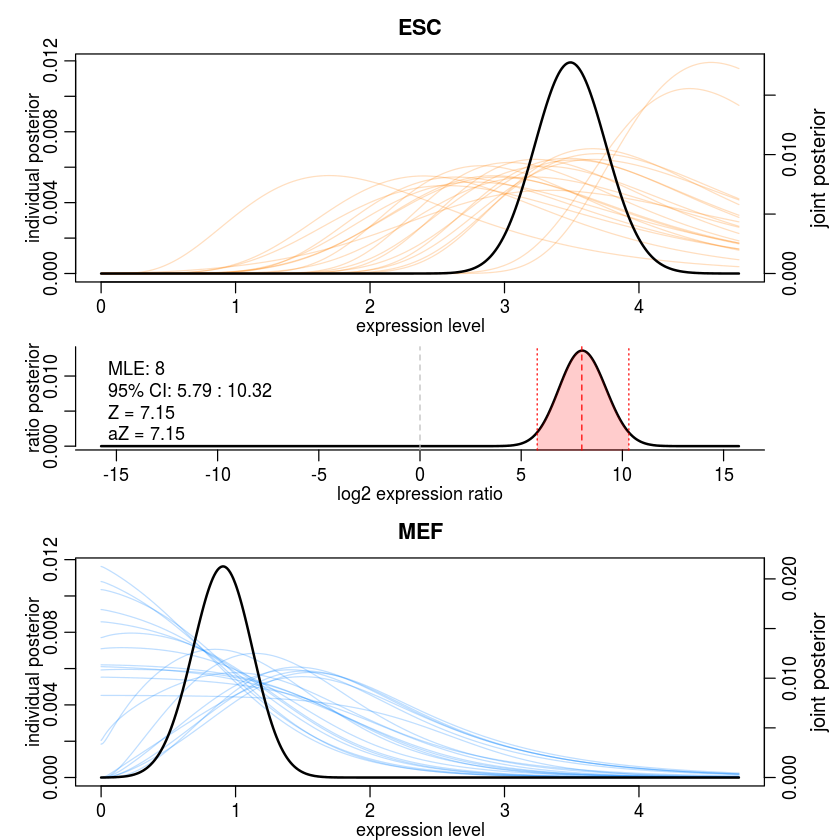

In [20]:
scde.test.gene.expression.difference("Tdh", models = o.ifm, counts = cd, prior = o.prior)